# Training a Classifier

This tutorial introduces how to use `pytagi` to train a simple model that is able to classify the digits from the MNIST dataset using a CNN with batch normalization. Run it now in [Google Colab](https://colab.research.google.com/drive/1-1JOjmfUrL106nf2u5zXzN6o-zHVlU51?usp=sharing).

## Load and normalize MNIST

In this tutorial we will make use of `torch` and `torchvision` to load and normalize the MNIST images. We define the batch size as well for the data processing.

In [1]:
# Uncomment the following lines to install the required packages if not already installed
# !pip install pytagi
# !pip install numpy
# !pip install tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

We create a custom collate function

In [2]:
def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor and then to numpy
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images and labels to 1D
    batch_images = batch_images.numpy().reshape(len(batch_images), -1).flatten()
    batch_labels = batch_labels.numpy().flatten()

    return batch_images, batch_labels

In [3]:
# Data loading and preprocessing
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=custom_collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    collate_fn=custom_collate_fn,
)


We can see some of the MNIST images :)

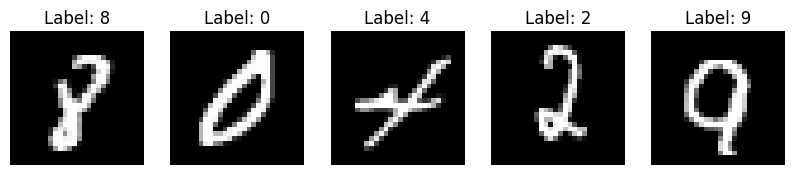

In [4]:
import matplotlib.pyplot as plt

# Get a batch from the training data loader
# Note: The custom_collate_fn flattens the data, so we need to reshape it back to image format (28x28)
# Also, the original images are grayscale, so we don't need a color map.
images, labels = next(iter(train_loader))

# Reshape the flattened images back to 28x28 for plotting
images = images.reshape(-1, 1, 28, 28)

# Display a few images
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')
plt.show()

## Define a Convolutional Neural Network

Next we define our convolutional network. Because the images are in grayscale, we specify one channel in the entrance as well as the dimension of the images. We also use average pooling after the batch normalization and use ReLU as activation function.

In [5]:
from pytagi.nn import (
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    Linear,
    OutputUpdater,
    ReLU,
    Sequential,
)

CNN_BATCHNORM = Sequential(
    Conv2d(1, 32, 4, padding=1, in_width=28, in_height=28, bias=False),
    ReLU(),
    BatchNorm2d(32),
    AvgPool2d(3, 2),
    Conv2d(32, 64, 5, bias=False),
    ReLU(),
    BatchNorm2d(64),
    AvgPool2d(3, 2),
    Linear(64 * 4 * 4, 256),
    ReLU(),
    Linear(256, 11), # We use Hierarchical Softmax
)


## Train the network

We need to first load the nework, instanciate our output updater, utils and metric classes. On the other side we will make use of the [Hierarchical Softmax](https://building-babylon.net/2017/08/01/hierarchical-softmax) in the output, so we will have to specify 11 units in the output layer and use the `out_updater.update_using_indices` function.

In [6]:
net = CNN_BATCHNORM

from pytagi import HRCSoftmaxMetric, Utils

utils = Utils()
# Hierachical Softmax
metric = HRCSoftmaxMetric(num_classes=10)

In this step we can also make our model run on GPU in case we have CUDA.

In [7]:
import pytagi
net.to_device("cuda" if pytagi.cuda.is_available() else "cpu")

# We can also set number of threads if we run on CPU
# net.set_threads(8)

out_updater = OutputUpdater(net.device)

We need to also specify a sigma_v, which corresponds to the noise of the data.

In [8]:
# Training
error_rates = []
num_epochs = 5
sigma_v = 0.2

pbar = tqdm(range(num_epochs), desc="Training Progress")
var_y = np.full(
        (batch_size * metric.hrc_softmax.num_obs,),
        sigma_v**2,
        dtype=np.float32,
    )

for epoch in pbar:
    net.train()

    for x, labels in train_loader:
        # Feedforward and backward pass
        m_pred, v_pred = net(x)

        # Update output layers based on targets
        y, y_idx, _ = utils.label_to_obs(labels=labels, num_classes=10)
        out_updater.update_using_indices(
            output_states=net.output_z_buffer,
            mu_obs=y,
            var_obs=var_y,
            selected_idx=y_idx,
            delta_states=net.input_delta_z_buffer,
        )

        # Update parameters
        net.backward()
        net.step()

        # Training metric
        error_rate = metric.error_rate(m_pred, v_pred, labels)
        error_rates.append(error_rate)

    # Averaged error
    avg_error_rate = sum(error_rates[-100:])

    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs} | training error: {avg_error_rate:.2f}%",
        refresh=False,
    )
print("Training complete.")

Epoch 5/5 | training error: 0.78%: 100%|██████████| 5/5 [01:03<00:00, 12.73s/it]

Training complete.


## Test the model

In [9]:
# Testing
test_error_rates = []
net.eval()
for x, labels in test_loader:
    m_pred, v_pred = net(x)

    # Training metric
    error_rate = metric.error_rate(m_pred, v_pred, labels)
    test_error_rates.append(error_rate)

test_error_rate = sum(test_error_rates) / len(test_error_rates)
print(f"Test error: {test_error_rate * 100:.2f}%")


Test error: 0.85%


We can now try to visualize some of the predictions.

In [10]:
def visualize_predictions(model, dataloader, num_images=5):
    """
    Visualizes the model's predictions on a batch of images.

    Args:
        model: The trained pytagi model.
        dataloader: The DataLoader for the dataset to visualize.
        num_images: The number of images to display.
    """
    model.eval()
    images, labels = next(iter(dataloader))

    # Reshape the flattened images back to 28x28 for plotting
    images_reshaped = images.reshape(-1, 1, 28, 28)

    m_pred, v_pred = model(images)
    predicted_labels, _ = utils.get_labels(
        m_pred,
        v_pred,
        metric.hrc_softmax,
        num_classes=10,
        batch_size=batch_size,
    )

    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
    for i in range(num_images):
        axes[i].imshow(images_reshaped[i].squeeze(), cmap='gray')
        axes[i].set_title(f"True: {labels[i]}\nPred: {predicted_labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## Visualize Predictions

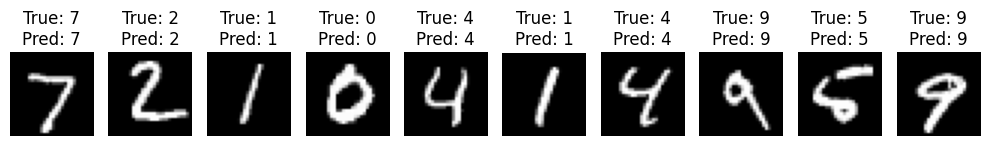

In [11]:
# Visualize predictions on a batch from the test set
visualize_predictions(net, test_loader, num_images=10)